In [1]:
from __future__ import division

from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

import sphereml
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py
import lcmaes
import time
import functions

from persistence import save, load
from joblib import Parallel, delayed
import pyformulas as pf

factor = 1.3

In [76]:
def run_evaluation(func_n, dims, algo, n_it, popsize=None, sbbx_eta=1.0, log=False, corrupt_first_guess=False, 
                   seed=283636):
    # TODO: use seed everywhere
    func = getattr(functions, f"f{func_n}")
    lb = functions.lbound[func_n - 1]
    rb = functions.rbound[func_n - 1]
    
    def magic_cast(a):
        if type(a) is np.ndarray:
            return a
        else:
            return np.array(a)
    
    def helper(ind):
        helper.calls += 1
        return -func(magic_cast(ind))
    helper.calls = 0
    
    hist = []
    limits = [(lb, rb)]*dims
    
    if popsize is None: popsize = 5*len(limits)
    if popsize > n_it: raise AssertionError(f"popsize({popsize}) should be < n_it({n_it})")
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=popsize, limits=limits)
        for _ in range(int(n_it/popsize)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, -func(magic_cast(xk))))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=popsize, maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=popsize, generations=n_it, sbbx_eta=sbbx_eta, log=False,
                            callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    elif algo == 'CMA':
        str_algo=b'acmaes'
        # the optimum should better not be far away from the interval [x0 - sigma0, x0 + sigma0] in each dimension
        if corrupt_first_guess:
            x0 = [(rb + 0) / 2] * dims
            sigma0 = rb / 3
        else:
            x0 = [(rb + lb) / 2] * dims
            sigma0 = (rb - lb) / 8

        # without scaling (see lcmaes_interface.py). affects both parameters and optimization function
        gp = lcmaes.make_genopheno_pwqb([lb]*dims,[rb]*dims,dims)
        p = lcmaes.make_parameters_pwqb(x0,sigma0,gp)
        optimizer = lcmaes.pcmaes_pwqb2
        #sigma0=0.01
        
        # with scaling
        #gp = lcmaes.make_genopheno_pwqb_ls([lb]*dims,[rb]*dims,dims)
        #p = lcmaes.make_parameters_pwqb_ls(x0,sigma0,gp,-1,0)
        #optimizer = lcmaes.pcmaes_pwqb_ls2
        
        p.set_str_algo(str_algo)
        #p.set_quiet(False)
        objfunc = lcmaes.fitfunc_pbf.from_callable(lambda x, n: -helper(x))
        
        def pfunc_raw(fitness):
            if np.isnan(fitness):
                return 0
            hist.append((helper.calls, -fitness))
            if helper.calls > n_it:
                #print("STOP")
                return 1
            return 0
        
        pfunc = lcmaes.pfunc_pbf.from_callable(pfunc_raw)
        
        results = optimizer(objfunc, p, pfunc)
        bestie = results.best_candidate()
        
        fit, best = -bestie.get_fvalue(), lcmaes.get_candidate_x(bestie)
    else:
        raise AssertionError("Unknown algo")
    
    if log:
        print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

def run_evaluations(runs=50, *args, **kwargs):
    res = []
    for run in range(runs):
        _, _, hist = run_evaluation(*args, **kwargs)
        res.append(hist)
    return np.array(res)

cmabest, cmafit, cma = run_evaluation(func_n=1, dims=30, algo='CMA', n_it=100000, corrupt_first_guess=True)
print(cmafit)

-4.782410192202472e-271


In [47]:
r = run_evaluations(runs=10, func_n=1, dims=30, algo='JADE', n_it=10000)

In [49]:
%%time

res = {}

for (n_it, dims) in [(100000, 100)]:#[(50000, 30), (100000, 100)]:
    res[dims] = {}
    for func_n in [8, 10]:#range(1, 14):
        res[dims][func_n] = {}
        print(f"{dims} f{func_n}")
        for algo in ['CMA']:#['JADE', 'CMA', 'genetic', '1+1']: #'DE',
            print(f"{algo}")
            RUNS=3
            r = run_evaluations(runs=RUNS, func_n=func_n, dims=dims, algo=algo, n_it=n_it, corrupt_first_guess=False)
            
            if algo == '1+1' or algo == 'CMA':
                length = min(map(len, r))
                r = np.array([np.array(xi)[:length] for xi in r])
            else:
                r = np.array(r)
            ggr=r
            
            #mean = r.mean(axis=0)
            max_ = r[0]
            for cand in r:
                if cand[-1,1] > max_[-1,1]:
                    max_=cand
            
            error = r.max(axis=0) - r.mean(axis=0)

            res[dims][func_n][algo] = (max_, error[:,1])
            
save(res, "results/f/temp_res2")

100 f8
CMA
100 f10
CMA
CPU times: user 11min 6s, sys: 1.13 s, total: 11min 7s
Wall time: 3min 4s


In [50]:
all_res = load("results/f/all_res")
for dims in res.keys():
    for func_n in res[dims].keys():
        for algo in res[dims][func_n].keys():
            all_res[dims][func_n][algo] = res[dims][func_n][algo]
res = all_res

In [31]:
res = load("results/f/temp_res2")

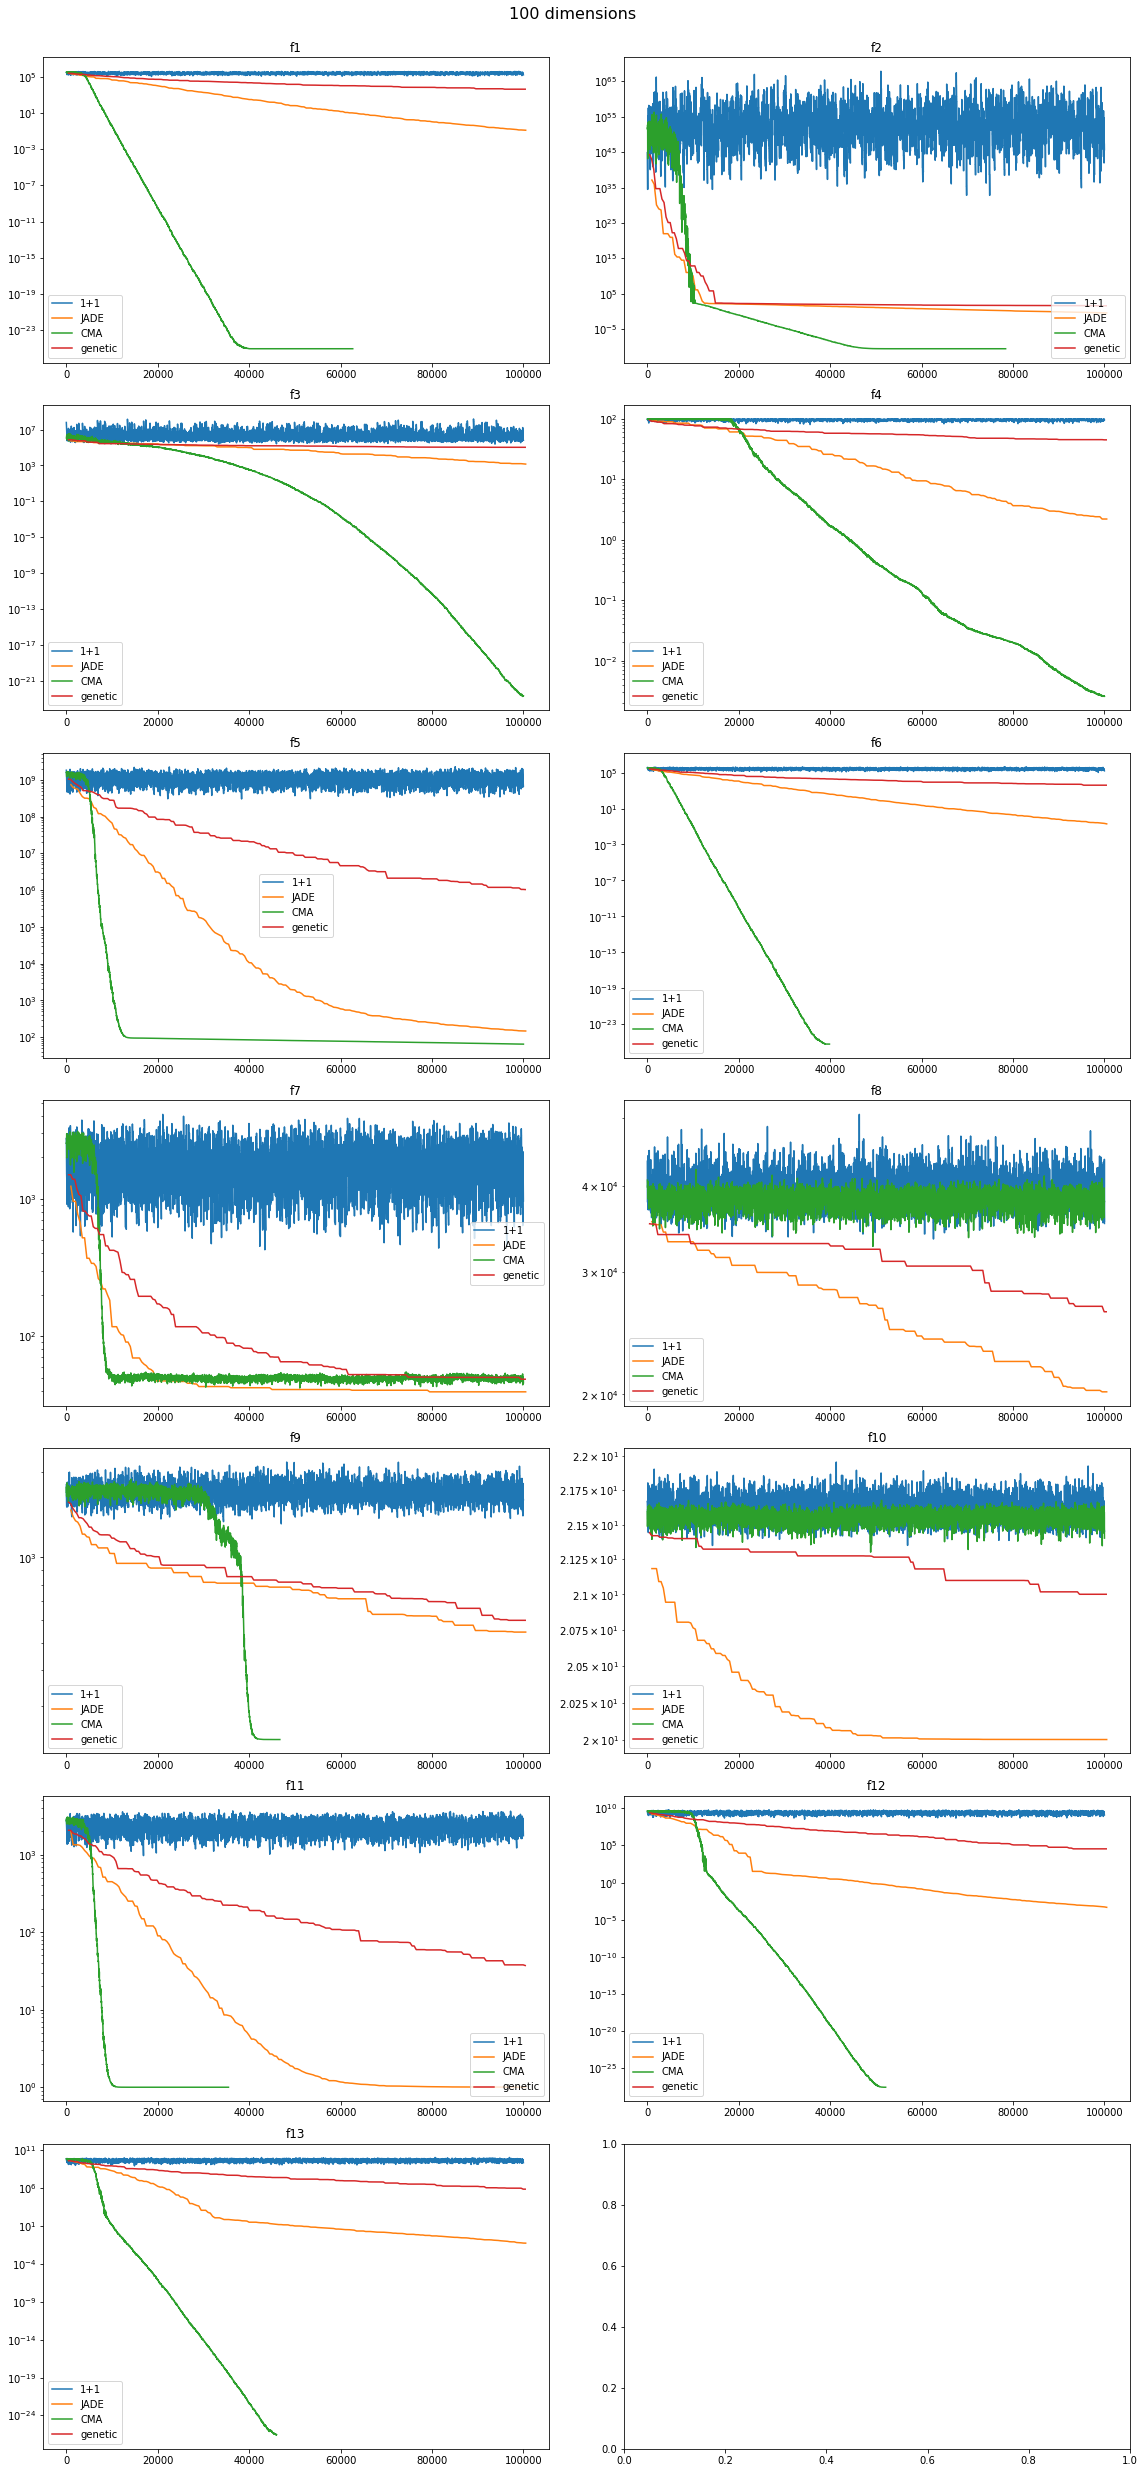

In [52]:
%matplotlib inline
fig, axes = plt.subplots(7, 2, figsize=(16,5*7))

dims = 100
fig.suptitle(f'{dims} dimensions', fontsize=16)
for func_n in range(0, 13):
    ax = axes[func_n // 2, func_n % 2]
    ax.set_title(f"f{func_n + 1}")
    
    for algo in ['1+1', 'JADE', 'CMA', 'genetic']:
        r = res[dims][func_n + 1][algo]
        
        xs = r[0][:,0]
        ys = -r[0][:,1]
        error = r[1]
        if True or algo == '1+1':
            ax.plot(xs, ys, label=algo)
        else:
            ax.errorbar(xs, ys, yerr=error, fmt='-o', label=algo)
        ax.set_yscale('log')
        ax.legend();
        
fig.tight_layout()
fig.subplots_adjust(top=0.96)

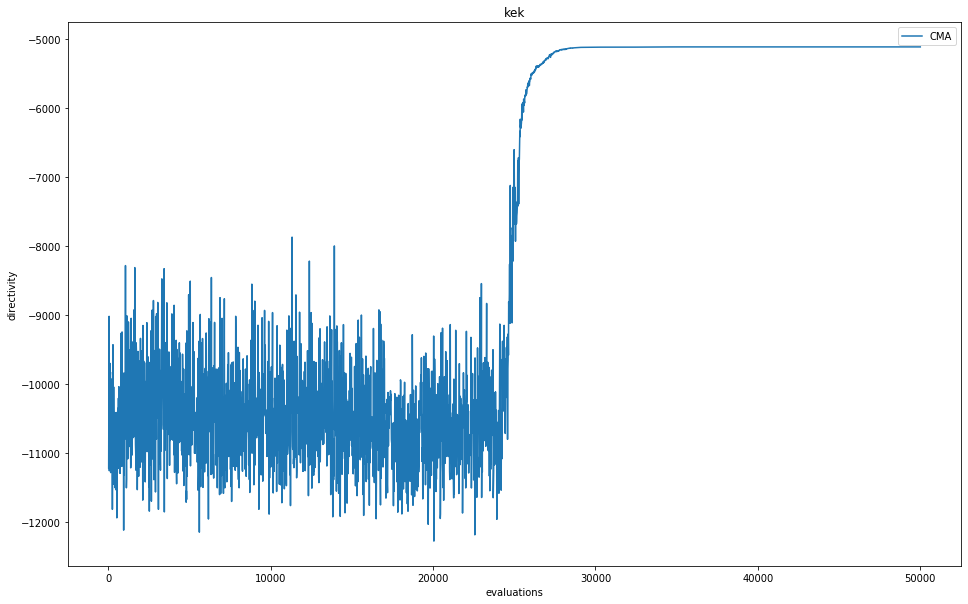

In [35]:
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("kek")
for algo in ['CMA']:#['JADE', 'DE', 'genetic', '1+1']:
    xs = res[30][8][algo][0][:,0]
    ys = res[30][8][algo][0][:,1]
    #error = res[30][1][algo][1]
    #if algo == '1+1':
    plt.plot(xs, ys, label=algo)
    #else:
    #    plt.errorbar(xs, ys, yerr=error, fmt='-o', label=algo)
plt.legend();

<IPython.core.display.Javascript object>


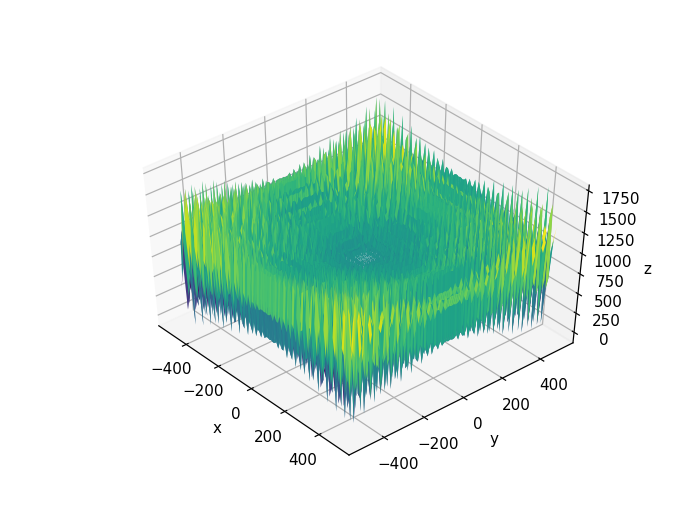

In [46]:
%matplotlib notebook

def plot_func(func_n):
    func = getattr(functions, f"f{func_n}")
    lb = functions.lbound[func_n - 1]
    rb = functions.rbound[func_n - 1]
    
    xs = np.linspace(lb, rb, 100)
    ys = np.linspace(lb, rb, 100)
    Xs, Ys = np.meshgrid(xs, ys)
    Zs = np.vectorize(lambda x, y: func(np.array([x, y])))(Xs, Ys)

    fig = plt.figure()#figsize=(16,10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(Xs, Ys, Zs, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z');

plot_func(8)